# Analysis of mainnet transaction validation times

## Setup

In [1]:
suppressMessages({
    require(data.table, quietly=TRUE)
    require(ggplot2, quietly=TRUE)
    require(magrittr, quietly=TRUE)
    require(VGAM, quietly=TRUE)
})

### Generate data

We use the `db-analyser` tool:

```bash
nix build 'github:IntersectMBO/ouroboros-consensus/release-ouroboros-consensus-diffusion-0.20.0.0#db-analyser'
```

Measure CPU usage starting from [Epoch 350](https://cardanoscan.io/block/7477993) and doing full application of blocks.

```bash
db-analyser \
  --verbose \
  --db node.db/ \
  --analyse-from 65836843 \
  --benchmark-ledger-ops \
    --out-file ledger-ops-apply-65836843.csv \
  cardano --config node.json
```

Re-measure CPU usage but only reapplying blocks.

```bash
db-analyser \
  --verbose \
  --db node.db/ \
  --analyse-from 65836843 \
  --benchmark-ledger-ops \
    --out-file ledger-ops-reapply-65836843.csv \
    --reapply \
  cardano --config node.json
```

The dominant difference between application and reapplication is the verification of transaction signatures and the execution of Plutus scripts.

<font color="red">WARNING: The measurements must be made on an otherwise idle machine because other CPU-heavy processes will interfere with the accuracy of `db-analyser`.</font>

## Read data

### Application

In [2]:
timingsApply <- fread("ledger-ops-apply-65836843.csv.gz")[
    `slot` >= 65836843, # Epoch 350
    .(
        `Slot`=`slot`,
        `Block [kB]`=`blockBytes`/1000,
        `Tx count`=as.numeric(`txs`),
        `Tx size [kB]`=txs_size/1000,
        `Tx exec [step]`=as.numeric(`txs_steps`),
        `Apply CPU [ms]`=`totalTime`/1000
    )
]
timingsApply %>% summary

      Slot             Block [kB]        Tx count       Tx size [kB]   
 Min.   : 65836984   Min.   : 0.864   Min.   :  0.00   Min.   : 0.000  
 1st Qu.: 89833176   1st Qu.: 6.235   1st Qu.:  4.00   1st Qu.: 5.369  
 Median :113740091   Median :20.825   Median : 10.00   Median :19.962  
 Mean   :113666120   Mean   :31.091   Mean   : 14.19   Mean   :30.231  
 3rd Qu.:137528206   3rd Qu.:50.030   3rd Qu.: 21.00   3rd Qu.:49.175  
 Max.   :161151612   Max.   :90.061   Max.   :385.00   Max.   :89.053  
 Tx exec [step]      Apply CPU [ms]     
 Min.   :0.000e+00   Min.   :    0.068  
 1st Qu.:4.381e+08   1st Qu.:    0.481  
 Median :2.024e+09   Median :    0.923  
 Mean   :3.272e+09   Mean   :    1.631  
 3rd Qu.:5.067e+09   3rd Qu.:    1.773  
 Max.   :3.625e+10   Max.   :30172.027  

### Reapplication

In [3]:
timingsReapply <- fread("ledger-ops-reapply-65836843.csv.gz")[
    `slot` >= 65836843, # Epoch 350
    .(
        `Slot`=`slot`,
        `Reapply CPU [ms]`=`totalTime`/1000
    )
]
timingsReapply %>% summary

      Slot           Reapply CPU [ms]   
 Min.   : 65836984   Min.   :    0.068  
 1st Qu.: 89833176   1st Qu.:    0.483  
 Median :113740091   Median :    0.927  
 Mean   :113666120   Mean   :    1.644  
 3rd Qu.:137528206   3rd Qu.:    1.770  
 Max.   :161151612   Max.   :31563.911  

### Join the datasets

In [4]:
timings <- timingsApply[timingsReapply, on="Slot"]
timings[, `Apply - Reapply CPU [ms]`:=`Apply CPU [ms]`-`Reapply CPU [ms]`]
timings %>% summary

      Slot             Block [kB]        Tx count       Tx size [kB]   
 Min.   : 65836984   Min.   : 0.864   Min.   :  0.00   Min.   : 0.000  
 1st Qu.: 89833176   1st Qu.: 6.235   1st Qu.:  4.00   1st Qu.: 5.369  
 Median :113740091   Median :20.825   Median : 10.00   Median :19.962  
 Mean   :113666120   Mean   :31.091   Mean   : 14.19   Mean   :30.231  
 3rd Qu.:137528206   3rd Qu.:50.030   3rd Qu.: 21.00   3rd Qu.:49.175  
 Max.   :161151612   Max.   :90.061   Max.   :385.00   Max.   :89.053  
 Tx exec [step]      Apply CPU [ms]      Reapply CPU [ms]   
 Min.   :0.000e+00   Min.   :    0.068   Min.   :    0.068  
 1st Qu.:4.381e+08   1st Qu.:    0.481   1st Qu.:    0.483  
 Median :2.024e+09   Median :    0.923   Median :    0.927  
 Mean   :3.272e+09   Mean   :    1.631   Mean   :    1.644  
 3rd Qu.:5.067e+09   3rd Qu.:    1.773   3rd Qu.:    1.770  
 Max.   :3.625e+10   Max.   :30172.027   Max.   :31563.911  
 Apply - Reapply CPU [ms]
 Min.   :-2701.4260      
 1st Qu.:   -0.03

### Cleanup

A few blocks have anomalously large times.

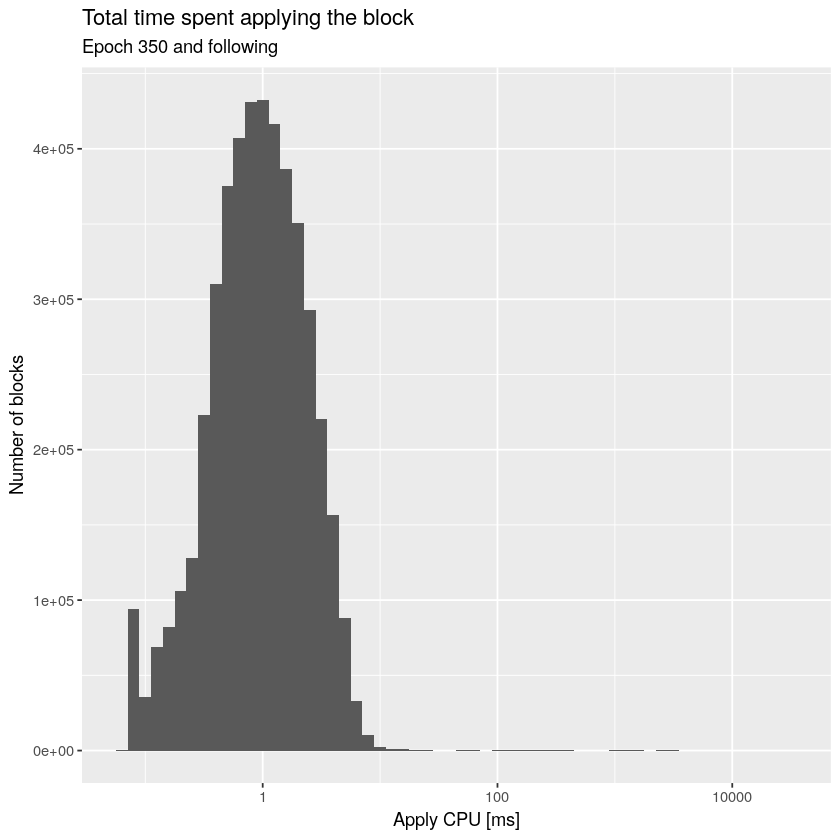

In [5]:
ggplot(timings, aes(x=`Apply CPU [ms]`)) +
    geom_histogram(binwidth=0.1) +
    scale_x_log10() +
    ylab("Number of blocks") +
    ggtitle(
        "Total time spent applying the block",
        "Epoch 350 and following"
    )

Ignore blocks that exceed the 99.9 %tile in CPU time because presumably there is something anomalous about these.

In [6]:
timeLimit <- timings[`Tx count` > 0, quantile(`Apply CPU [ms]`, 0.999)]
timeLimit

99.9% 
12.37013

## Basic statistics

In [7]:
basics <- timings[
    `Tx count` > 0 & `Apply CPU [ms]` <= timeLimit & `Reapply CPU [ms]` <= `Apply CPU [ms]`,
    .(
        `Apply CPU [ms/tx]`=`Apply CPU [ms]`/`Tx count`,
        `Reapply CPU [ms/tx]`=`Reapply CPU [ms]`/`Tx count`,
        `Delta CPU [ms/tx]`=(`Apply CPU [ms]`-`Reapply CPU [ms]`)/`Tx count`,
        `Apply CPU [ms/kB]`=`Apply CPU [ms]`/`Tx size [kB]`,
        `Reapply CPU [ms/kB]`=`Reapply CPU [ms]`/`Tx size [kB]`,
        `Delta CPU [ms/kB]`=(`Apply - Reapply CPU [ms]`)/`Tx size [kB]`
    ),
    .(
        `Slot`
    )
]
basics %>% summary

      Slot           Apply CPU [ms/tx] Reapply CPU [ms/tx] Delta CPU [ms/tx] 
 Min.   : 65836998   Min.   :0.03067   Min.   :0.03062     Min.   :0.000000  
 1st Qu.: 85857458   1st Qu.:0.07243   1st Qu.:0.06727     1st Qu.:0.001375  
 Median :104992476   Median :0.09411   Median :0.08435     Median :0.003676  
 Mean   :107725778   Mean   :0.13580   Mean   :0.11241     Mean   :0.023394  
 3rd Qu.:127014552   3rd Qu.:0.14271   3rd Qu.:0.12200     3rd Qu.:0.010286  
 Max.   :161151612   Max.   :7.28200   Max.   :6.91900     Max.   :5.262000  
 Apply CPU [ms/kB]   Reapply CPU [ms/kB] Delta CPU [ms/kB]  
 Min.   : 0.003556   Min.   : 0.003409   Min.   : 0.000000  
 1st Qu.: 0.030258   1st Qu.: 0.027559   1st Qu.: 0.000648  
 Median : 0.049332   Median : 0.043411   Median : 0.001946  
 Mean   : 0.109081   Mean   : 0.088818   Mean   : 0.020263  
 3rd Qu.: 0.096708   3rd Qu.: 0.083242   3rd Qu.: 0.006287  
 Max.   :14.478927   Max.   :11.081633   Max.   :13.835249  

### CPU time per transaction

In [8]:
melted <- melt(
    basics[, .(`Slot`, `Apply`=`Apply CPU [ms/tx]`, `Reapply`=`Reapply CPU [ms/tx]`, `Apply - Reapply`=`Delta CPU [ms/tx]`)],
    id.vars="Slot",
    measure.vars=c("Apply", "Reapply", "Apply - Reapply"),
    variable.name="Metric",
    value.name="CPU [ms/tx]"
)

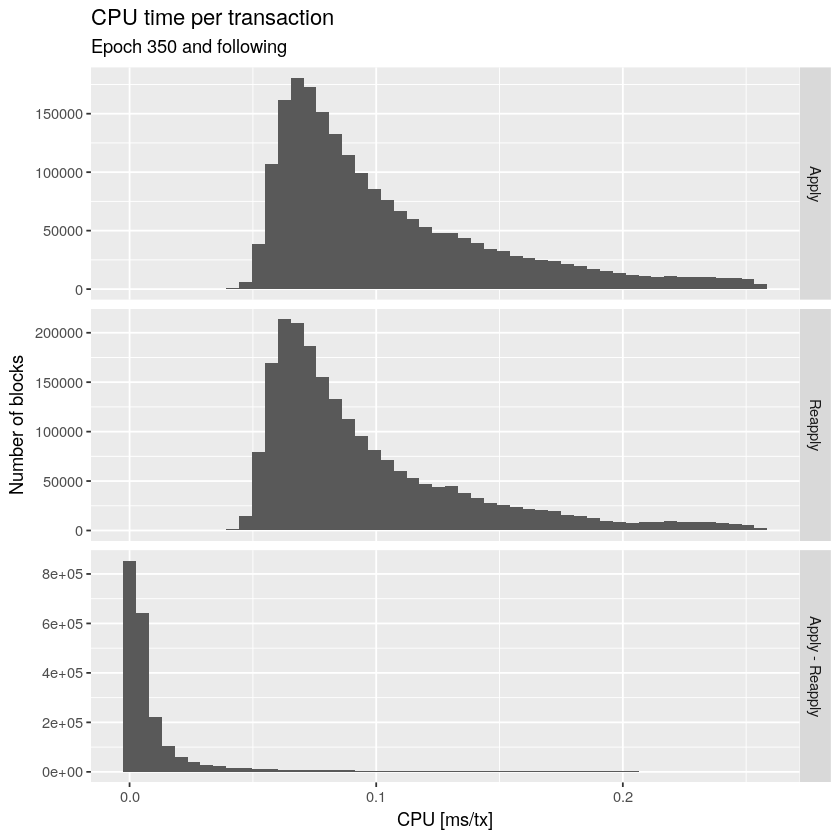

In [9]:
ggplot(melted[`CPU [ms/tx]` > 0 & `CPU [ms/tx]` < melted[, quantile(`CPU [ms/tx]`, 0.95)]], aes(x=`CPU [ms/tx]`)) +
    geom_histogram(bins=50) +
    ylab("Number of blocks") +
    facet_grid(`Metric` ~ ., scales="free_y") +
    ggtitle(
        "CPU time per transaction",
        "Epoch 350 and following"
    )

In [10]:
ggsave("cpu-per-tx.png", units="in", dpi=150, width=16, height=8)

In [11]:
melted[, .(`Median CPU [ms/tx]`=median(`CPU [ms/tx]`)), .(`Metric`)]

Metric,Median CPU [ms/tx]
<fct>,<dbl>
Apply,0.094111111
Reapply,0.084352941
Apply - Reapply,0.003675676


### CPU time per byte of transaction

In [12]:
melted <- melt(
    basics[, .(`Slot`, `Apply`=`Apply CPU [ms/kB]`, `Reapply`=`Reapply CPU [ms/kB]`, `Apply - Reapply`=`Delta CPU [ms/kB]`)],
    id.vars="Slot",
    measure.vars=c("Apply", "Reapply", "Apply - Reapply"),
    variable.name="Metric",
    value.name="CPU [ms/kB]"
)

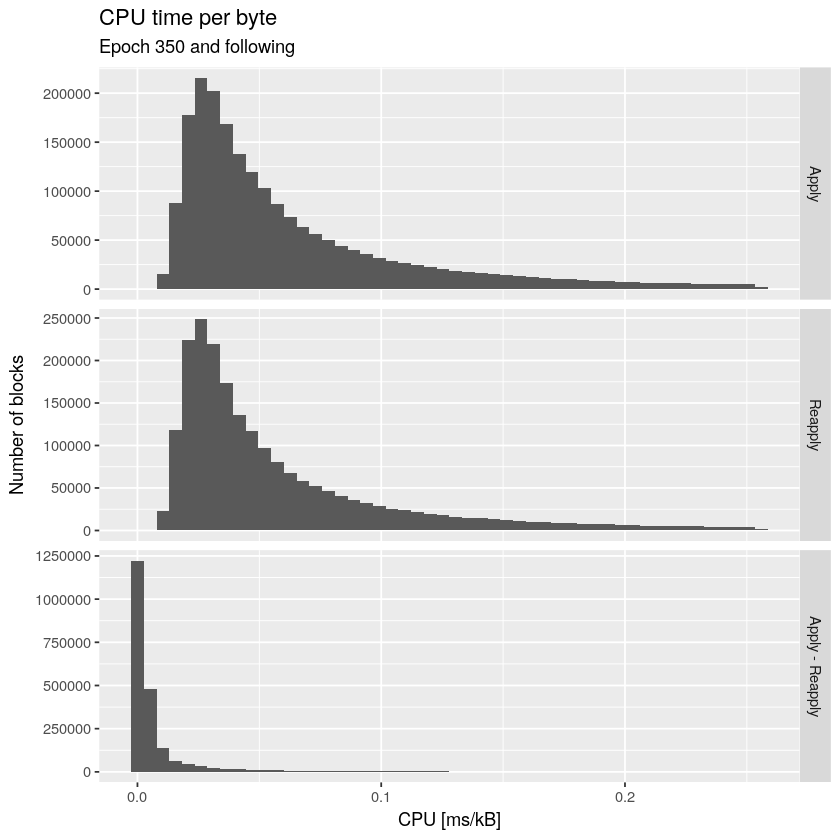

In [13]:
ggplot(melted[`CPU [ms/kB]` > 0 & `CPU [ms/kB]` < melted[, quantile(`CPU [ms/kB]`, 0.95)]], aes(x=`CPU [ms/kB]`)) +
    geom_histogram(bins=50) +
    ylab("Number of blocks") + 
    facet_grid(`Metric` ~ ., scales="free_y") +
    ggtitle(
        "CPU time per byte",
        "Epoch 350 and following"
    )

In [14]:
ggsave("cpu-per-kb.png", units="in", dpi=150, width=16, height=8)

In [15]:
melted[, .(`Median CPU [ms/kB]`=median(`CPU [ms/kB]`)), .(`Metric`)]

Metric,Median CPU [ms/kB]
<fct>,<dbl>
Apply,0.049332409
Reapply,0.043410714
Apply - Reapply,0.001946142


## Linear model

### Independent variables: transaction count and size

In [16]:
model <- lm(
    `Apply - Reapply CPU [ms]` ~ 0 + `Tx count` + `Tx size [kB]`, 
    timings[`Tx count` > 0 & `Apply CPU [ms]` <= timeLimit & `Reapply CPU [ms]` <= `Apply CPU [ms]`]
)
model %>% summary


Call:
lm(formula = `Apply - Reapply CPU [ms]` ~ 0 + `Tx count` + `Tx size [kB]`, 
    data = timings[`Tx count` > 0 & `Apply CPU [ms]` <= timeLimit & 
        `Reapply CPU [ms]` <= `Apply CPU [ms]`])

Residuals:
    Min      1Q  Median      3Q     Max 
-2.0325 -0.1425 -0.0484 -0.0007 10.4920 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
`Tx count`     7.353e-03  3.723e-05  197.52   <2e-16 ***
`Tx size [kB]` 1.474e-03  1.693e-05   87.05   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4692 on 2238455 degrees of freedom
Multiple R-squared:  0.169,	Adjusted R-squared:  0.169 
F-statistic: 2.277e+05 on 2 and 2238455 DF,  p-value: < 2.2e-16


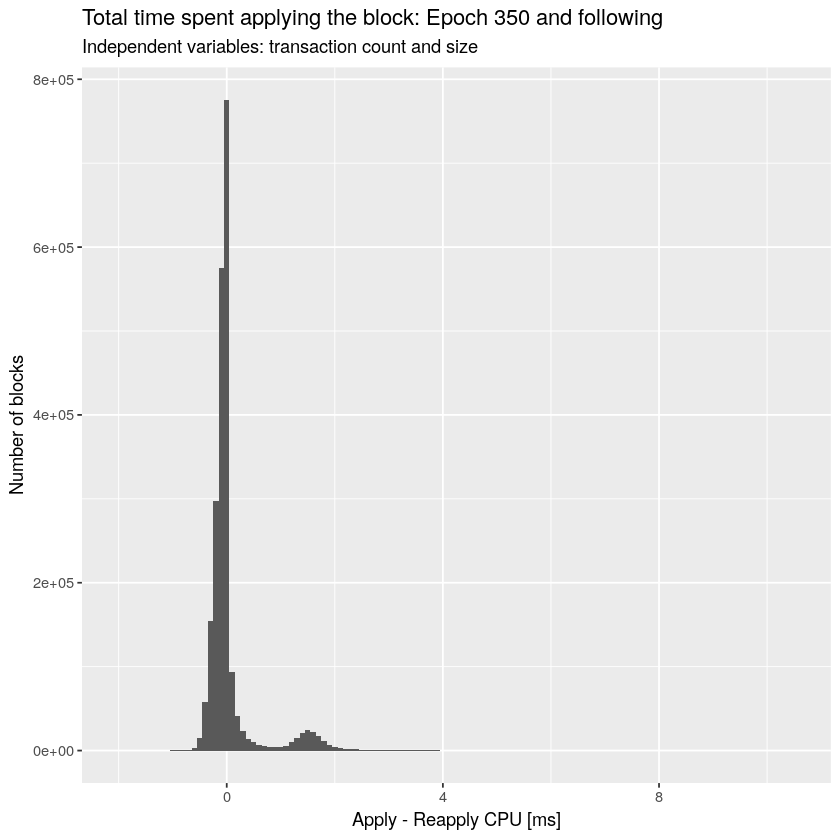

In [17]:
ggplot(data.table(`Actual - Fit [ms]`=residuals(model)), aes(`Actual - Fit [ms]`)) +
    geom_histogram(binwidth=0.1) +
    xlab("Apply - Reapply CPU [ms]") +
    ylab("Number of blocks") +
    ggtitle(
        "Total time spent applying the block: Epoch 350 and following",
        "Independent variables: transaction count and size"
    )

The resulting model for validating a block (signature checking and running Plutus scripts) is:

```
(validation time) ~ 7.353 μs/tx * (Number of transactions) + 1.474 μs/kB * (size of transactions)
```

### Independent variables: transaction count, size, and execution steps

In [18]:
model <- lm(
    `Apply - Reapply CPU [ms]` ~ 0 + `Tx count` + `Tx size [kB]` + `Tx exec [step]`, 
    timings[`Tx count` > 0 & `Apply CPU [ms]` <= timeLimit & `Reapply CPU [ms]` <= `Apply CPU [ms]`]
)
model %>% summary


Call:
lm(formula = `Apply - Reapply CPU [ms]` ~ 0 + `Tx count` + `Tx size [kB]` + 
    `Tx exec [step]`, data = timings[`Tx count` > 0 & `Apply CPU [ms]` <= 
    timeLimit & `Reapply CPU [ms]` <= `Apply CPU [ms]`])

Residuals:
    Min      1Q  Median      3Q     Max 
-1.9764 -0.1430 -0.0489 -0.0008 10.4947 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
`Tx count`       7.271e-03  3.728e-05  195.05   <2e-16 ***
`Tx size [kB]`   9.383e-04  2.193e-05   42.78   <2e-16 ***
`Tx exec [step]` 5.463e-12  1.425e-13   38.35   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4691 on 2238454 degrees of freedom
Multiple R-squared:  0.1696,	Adjusted R-squared:  0.1696 
F-statistic: 1.524e+05 on 3 and 2238454 DF,  p-value: < 2.2e-16


In [19]:
timingsFit <- cbind(
    timings[`Tx count` > 0 & `Apply CPU [ms]` <= timeLimit & `Reapply CPU [ms]` <= `Apply CPU [ms]`],
    data.table(`Residual [ms]`=residuals(model))
)
timingsFit %>% summary

      Slot             Block [kB]        Tx count       Tx size [kB]   
 Min.   : 65836998   Min.   : 1.053   Min.   :  1.00   Min.   : 0.159  
 1st Qu.: 85857458   1st Qu.: 8.820   1st Qu.:  5.00   1st Qu.: 7.953  
 Median :104992476   Median :25.227   Median : 11.00   Median :24.364  
 Mean   :107725778   Mean   :34.621   Mean   : 15.17   Mean   :33.758  
 3rd Qu.:127014552   3rd Qu.:56.608   3rd Qu.: 22.00   3rd Qu.:55.753  
 Max.   :161151612   Max.   :90.049   Max.   :268.00   Max.   :89.053  
 Tx exec [step]      Apply CPU [ms]   Reapply CPU [ms] Apply - Reapply CPU [ms]
 Min.   :0.000e+00   Min.   : 0.107   Min.   : 0.105   Min.   : 0.0000         
 1st Qu.:6.963e+08   1st Qu.: 0.571   1st Qu.: 0.524   1st Qu.: 0.0110         
 Median :2.455e+09   Median : 1.071   Median : 0.940   Median : 0.0350         
 Mean   :3.620e+09   Mean   : 1.486   Mean   : 1.280   Mean   : 0.2053         
 3rd Qu.:5.613e+09   3rd Qu.: 2.035   3rd Qu.: 1.679   3rd Qu.: 0.1180         
 Max.   :3.625e+

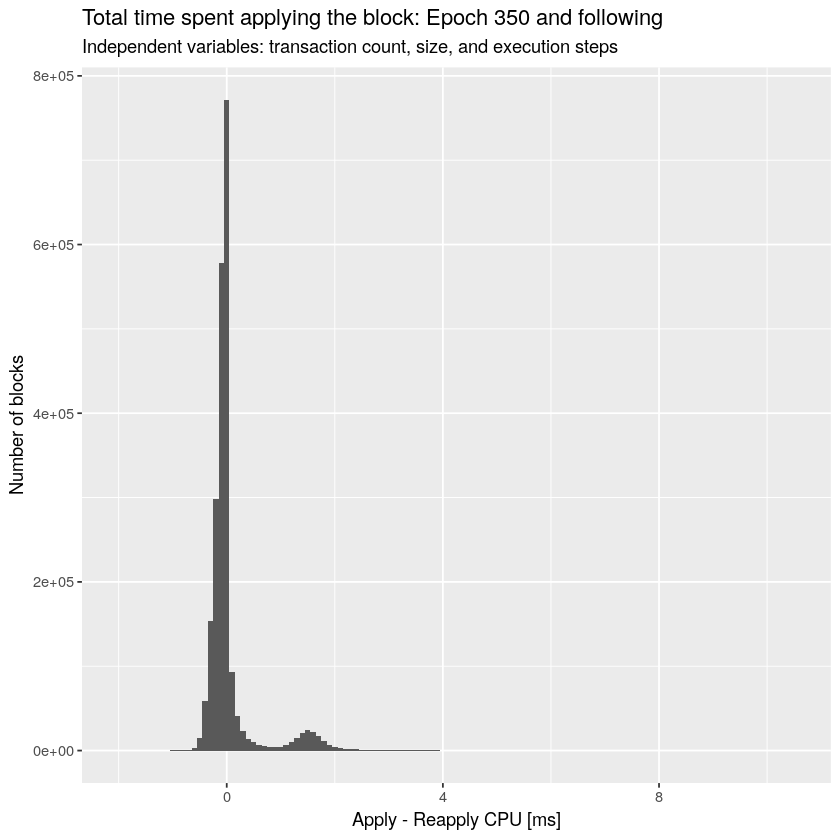

In [20]:
ggplot(timingsFit, aes(x=`Residual [ms]`)) +
    geom_histogram(binwidth=0.1) +
    xlab("Apply - Reapply CPU [ms]") +
    ylab("Number of blocks") +
    ggtitle(
        "Total time spent applying the block: Epoch 350 and following",
        "Independent variables: transaction count, size, and execution steps"
    )

In [21]:
ggsave("residual-histogram.png", units="in", dpi=150, width=16, height=8)

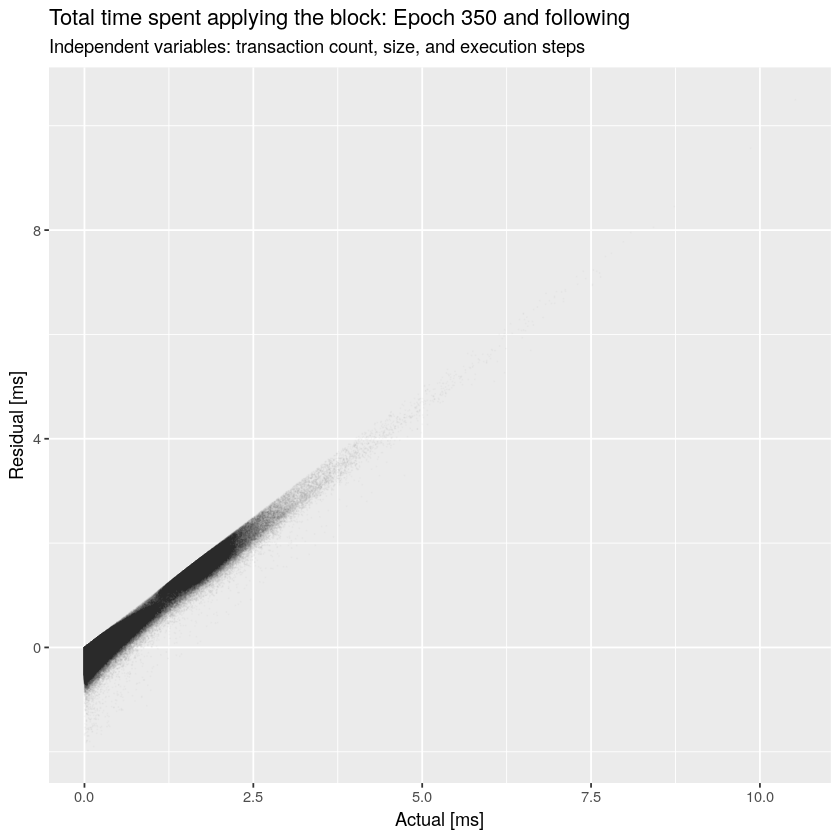

In [22]:
ggplot(
    timingsFit[, .(`Actual [ms]`=`Apply - Reapply CPU [ms]`, `Residual [ms]`)],
    aes(x=`Actual [ms]`, y=`Residual [ms]`)
) +
    geom_point(size=0.025, alpha=0.01) +
    ggtitle(
        "Total time spent applying the block: Epoch 350 and following",
        "Independent variables: transaction count, size, and execution steps"
    )

In [23]:
ggsave("residual-scatterplot.png", units="in", dpi=150, width=16, height=8)

The previous plot indicates that nonlinear terms are present, and that a more sophisticate model might be possible, though we do not pursue this.

It turns out that the distribution of residuals are fit pretty well by a [Laplace distribution](https://en.wikipedia.org/wiki/Laplace_distribution) with location 0 and scale 0.145. We ignore heteroscedasticity.

In [24]:
b <- 0.145

In [25]:
errorModel <- data.table(`Residual [ms]`=-30:30/10, `Fit`=nrow(timingsFit)*dlaplace(-30:30/10, 0, b))

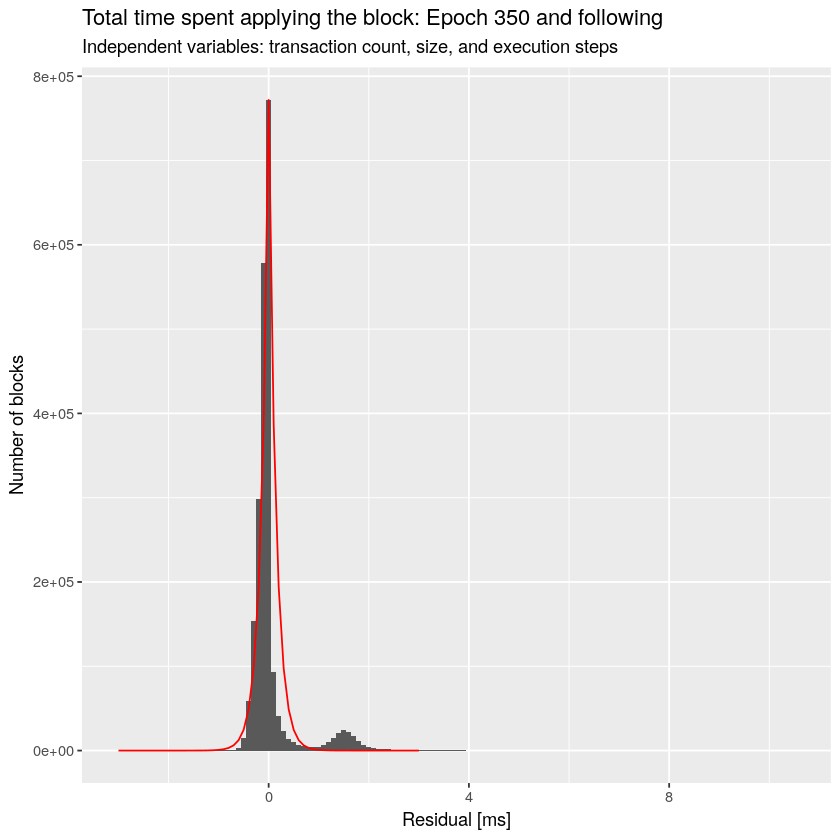

In [26]:
ggplot(timingsFit, aes(x=`Residual [ms]`)) +
    geom_histogram(binwidth=0.1) +
    geom_line(data=errorModel, aes(x=`Residual [ms]`, y=0.1*`Fit`), color="red") +
    ylab("Number of blocks") +
    ggtitle(
        "Total time spent applying the block: Epoch 350 and following",
        "Independent variables: transaction count, size, and execution steps"
    )

In [27]:
ggsave("residual-histogram-fit.png", units="in", dpi=150, width=16, height=8)

The resulting model for validating a block (signature checking and running Plutus scripts) is:

```
(validation time) ~ 7.271 μs/tx * (Number of transactions)
                  + 0.938 μs/kB * (size of transactions) 
                  + 5.463 μs/Gstep * (Plutus execution steps)
                  + (Laplace-distributed random variable with location 0 ms and scale 0.145 ms)
```

## Outliers

In [28]:
recentMax <- timings[`Slot` >= 160000000 & `Apply CPU [ms]` >= timings[`Slot` >= 160000000, max(`Apply CPU [ms]`)]]
recentMax

Slot,Block [kB],Tx count,Tx size [kB],Tx exec [step],Apply CPU [ms],Reapply CPU [ms],Apply - Reapply CPU [ms]
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
160444814,34.951,17,34.109,1810937370,3560.348,3501.57,58.778


This is [block 12100125](https://cexplorer.io/block/347993f8c93aa95a088c77732d054458597275e085bfdc9f00814e73e6f37000). Opening it in an explorer reveals that it contains several transactions with large number of NFTs and several Plutus scripts. Indeed, it did [propagate slowly](https://pooltool.io/realtime/12100125). Apparently, this is caused by [Cardano Ledger issue #3034](https://github.com/IntersectMBO/cardano-ledger/issues/3034).

Are these measures repeatable?

```bash
(
    for i in {1..10}
    do
        db-analyser --db node.db --analyse-from 160444759 --benchmark-ledger-ops --num-blocks-to-process 3 cardano --config node.json 2>/dev/null
    done
) | sed -n -e '1p;/160444814/p' | cut -f 1,3,4,5
```

```console
slot          totalTime     mut     gc
160444814       2837493 2185118 652375
160444814       2967857 2280091 687766
160444814       2900696 2227492 673203
160444814       2881636 2222040 659596
160444814       3289770 2471157 818612
160444814       2880495 2205710 674784
160444814       2911893 2237162 674731
160444814       2948804 2260896 687907
160444814       3028562 2335259 693303
160444814       2922908 2243885 679023
```

Also repeat the `--reapply` measurements.

```bash
(
    for i in {1..10}
    do
        db-analyser --db node.db --analyse-from 160444759 --benchmark-ledger-ops --reapply --num-blocks-to-process 3 cardano --config node.json 2>/dev/null
    done
) | sed -n -e '1p;/160444814/p' | cut -f 1,3,4,5
```

```console
slot          totalTime     mut     gc
160444814       2979251 2280452 698799
160444814       2926794 2252894 673899
160444814       2838160 2184320 653839
160444814       2948609 2267553 681056
160444814       2968821 2262615 706205
160444814       2887207 2220366 666840
160444814       2889603 2226234 663369
160444814       2889129 2217814 671315
160444814       2821164 2164449 656715
160444814       2848343 2195993 652349
```

These results also provide a sense of how noisy the measurements are.

## Findings

We undertook basic analysis of block and transaction validation times for Cardano `mainnet` since Epoch 350.

1. The `db-analyser` tool can be used to measure the Cardno block-application time, either including or not including verifying transaction signatures and running Plutus scripts.
2. Ideally, `db-analyser` could be modified to report CPU times for phase 1 and phase 2 validation on a per-transaction basis.
3. The output of this tool is quite noisy and does not include enough of the explanatory variable for predicting CPU times for transactions or blocks.
4. The missing explanatory variables (size of UTxO set, number of inputs, number of outputs, etc.) can be extracted from the ledger or `cardano-db-sync`.
5. For transaction signature verification and Plutus script execution, the median times are . . .
    - 3.675 μs/tx
    - 1.946 μs/kB
    - Jointly via a linear model, 7.353 μs/tx plus 1.474 μs/kB.
    - Jointly via a linear model, 7.271 μs/tx plus 0.938 μs/kB plus 5.463 μs/Gstep, with a Lapace-distributed error having location 0 μs and scale 145 μs.
6. The noise in the data and the uncertainty in predictions make the above values unsuitable for estimating individual transactions but suitable for bulk estimates of many blocks.
7. A more sophisticated double general linear model could be used to generate artificial transaction workloads.